In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
data=np.load("./olivetti_faces.npy")
target=np.load("./olivetti_faces_target.npy")
print(f"data shape : {data.shape}, target shape : {target.shape}") 

data shape : (400, 64, 64), target shape : (400,)


In [3]:
np.unique(target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39], dtype=int32)

In [4]:
def imshow_olivetti(data, target):
    plt.figure(figsize=(30, 12))
    idx = 1
    for i in range(0, 400, 10):
        plt.subplot(4, 10, idx)
        plt.title(f"id {idx}")
        idx+=1
        plt.axis('off')
        plt.imshow(data[i], cmap='gray')
    plt.show()
    # plt.savefig('/home/vcl/Desktop/final_project/fig1.png', pad_inches=0, bbox_inches='tight')

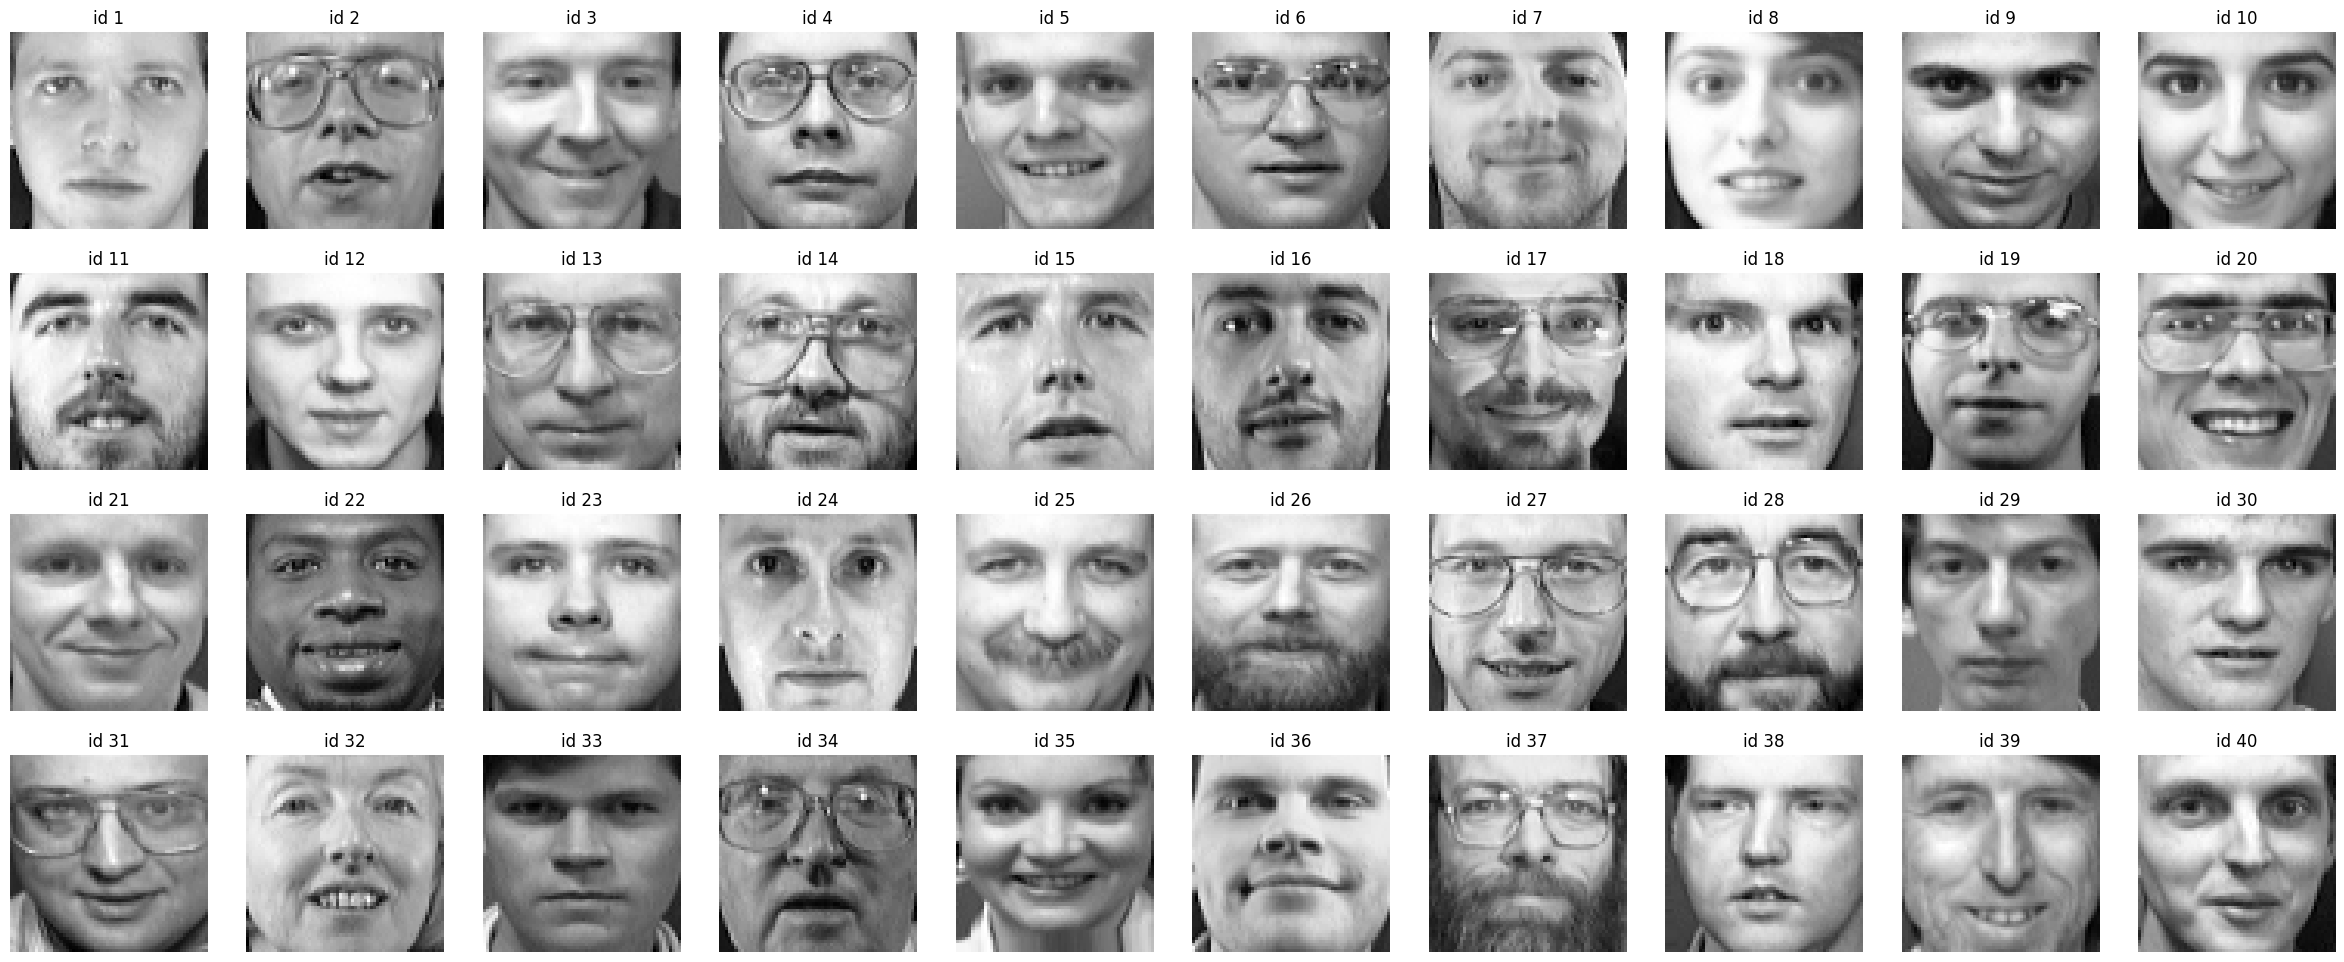

In [5]:
imshow_olivetti(data, target)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, stratify=target, random_state=0)

In [7]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(280, 64, 64) (120, 64, 64) (280,) (120,)


## SIFT classifier

In [12]:
def sift_classification(X_test, reference):
    pred = []
    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher()
    for x in tqdm.tqdm(X_test):
        rank = []
        img1 = (x*255).astype(np.uint8)
        kp1, des1 = sift.detectAndCompute(img1, None)
        for i, q in enumerate(reference):
            img2 = (q*255).astype(np.uint8)
            kp2, des2 = sift.detectAndCompute(img2, None)
            matches = bf.knnMatch(des1,des2, k=2)
            good = []
            for m, n in matches:
                if m.distance < 0.75 * n.distance:
                    good.append(m)
            
            rank.append((len(good), y_train[i]))
        pred.append(sorted(rank, key=lambda x : x[0])[::-1][0][1])
    pred = np.array(pred)
    print(f"accuracy : {(pred==y_test).sum()/y_test.shape[0]*100}\n")

In [13]:
sift_classification(X_test, X_train)

100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.69it/s]

accuracy : 96.66666666666667



## SVM classifier

In [11]:
from sklearn.svm import SVC
svm = SVC(random_state=0, C= 1.2)
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
svm.fit(X_train_reshaped, y_train)
pred =svm.predict(X_test_reshaped)
svm_acc = (y_test == pred).sum()/y_test.shape[0]
print("accuracy : ", svm_acc*100)

accuracy :  91.66666666666666


## gaussian blurred & rotated dataset

In [14]:
import torch, torchvision
import random
from PIL import Image

random.seed(0) 
torch.manual_seed(0)

sigma_range = (0.1, 1.0)
degree = 20

transforms_blur = torch.nn.Sequential(
    torchvision.transforms.GaussianBlur(3, sigma=sigma_range),
)
transforms_rotate = torch.nn.Sequential(
    torchvision.transforms.RandomRotation(degrees=(-degree, degree))
)
transforms_both = torch.nn.Sequential(
    torchvision.transforms.GaussianBlur(3, sigma=sigma_range),
    torchvision.transforms.RandomRotation(degrees=(-degree, degree))
)


X_test_blurred = []
for x in X_test:
    X_test_blurred.append(np.asarray(transforms_blur(Image.fromarray((x*255).astype(np.uint8)))))
X_test_blurred = np.array(X_test_blurred)
X_test_rotated = []
for x in X_test:
    X_test_rotated.append(np.asarray(transforms_rotate(Image.fromarray((x*255).astype(np.uint8)))))
X_test_rotated = np.array(X_test_rotated)
X_test_both = []
for x in X_test:
    X_test_both.append(np.asarray(transforms_both(Image.fromarray((x*255).astype(np.uint8)))))
X_test_both = np.array(X_test_both)

X_test_blurred -> testset2  
X_test_rotated -> testset3  
X_test_both    -> testset4  

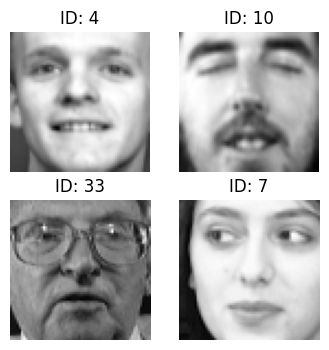

In [15]:
plt.figure(figsize=(4,4))
# plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title(f"ID: {y_test[i]}")
    plt.axis(False)
    plt.imshow(X_test_blurred[i], cmap='gray')
# plt.savefig('/home/vcl/Desktop/final_project/fig10.png', bbox_inches='tight')
    

In [17]:
import tqdm
def sift_classification(X_test, reference):
    pred = []
    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher()
    for x in tqdm.tqdm(X_test):
        rank = []
        img1 = (x*255).astype(np.uint8)
        kp1, des1 = sift.detectAndCompute(img1, None)
        for i, q in enumerate(reference):
            img2 = (q*255).astype(np.uint8)
            kp2, des2 = sift.detectAndCompute(img2, None)
            matches = bf.knnMatch(des1,des2, k=2)
            good = []
            for m, n in matches:
                if m.distance < 0.75 * n.distance:
                    good.append(m)
            
            rank.append((len(good), y_train[i]))
        pred.append(sorted(rank, key=lambda x : x[0])[::-1][0][1])
    pred = np.array(pred)
    print('accuracy : ', (pred==y_test).sum()/y_test.shape[0]*100)

In [23]:
sift_classification(X_test, X_train)         # testset1
sift_classification(X_test_blurred/255., X_train) # testset2
sift_classification(X_test_rotated/255., X_train) # testset3
sift_classification(X_test_both/255., X_train)    # testset4

100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.67it/s]


accuracy :  96.66666666666667


100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.65it/s]


accuracy :  96.66666666666667


100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.66it/s]


accuracy :  94.16666666666667


100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.65it/s]

accuracy :  94.16666666666667


In [19]:
def svm_Classifier(X_test):
    X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))    
    pred =svm.predict(X_test_reshaped)
    svm_acc = (y_test == pred).sum()/y_test.shape[0]
    print("accuracy : ", svm_acc*100)

In [22]:
svm_Classifier(X_test)
svm_Classifier(X_test_blurred/255.)
svm_Classifier(X_test_rotated/255.)
svm_Classifier(X_test_both/255.)

accuracy :  91.66666666666666
accuracy :  90.83333333333333
accuracy :  55.00000000000001
accuracy :  45.83333333333333


# 

## Optimization (parameter tuning)

In [10]:
# def sift_classification(X_test, reference, options):
#     pred = []
#     s, n, e, c = options
#     sift = cv2.SIFT_create()
#     sift.setSigma(s)
#     sift.setNOctaveLayers(n)
#     sift.setEdgeThreshold(e)
#     sift.setContrastThreshold(c)

#     try:
#         bf = cv2.BFMatcher()
#         for x in tqdm.tqdm(X_test):
#             rank = []
#             img1 = (x*255).astype(np.uint8)
#             kp1, des1 = sift.detectAndCompute(img1, None)
#             for i, q in enumerate(reference):
#                 img2 = (q*255).astype(np.uint8)
#                 kp2, des2 = sift.detectAndCompute(img2, None)
#                 matches = bf.knnMatch(des1,des2, k=2)
#                 good = []
#                 for m, n in matches:
#                     if m.distance < 0.75 * n.distance:
#                         good.append(m)
                
#                 rank.append((len(good), y_train[i]))
#             pred.append(sorted(rank, key=lambda x : x[0])[::-1][0][1])
#         pred = np.array(pred)
#         print(f"accuracy : {(pred==y_test).sum()/y_test.shape[0]*100}\n")
#         f = open('./log.txt', 'a')
#         f.write(f"accuracy : {(pred==y_test).sum()/y_test.shape[0]*100}\n")
#         f.close()
#     except:
#         f = open('./log.txt', 'a')
#         f.write(f"error")
#         f.close()


In [ ]:

# sigmas = np.arange(0.4,2, 0.2)
# NOctaveLayers = [1, 3, 5, 7]
# EdgeThreshold = [6, 8, 10, 12]
# ContrastThreshold = np.arange(0.02, 0.08, 0.02)

# for s in sigmas:
#     for n in NOctaveLayers:
#         for e in EdgeThreshold:
#             for c in ContrastThreshold:
#                 f = open('./log.txt', 'a')
#                 f.write(f"sigma : {s}, octv : {n}, edgeTH : {e}, conTH : {c}\n")
#                 f.close()
#                 option = [s, n, e, c]
#                 sift_classification(X_test, X_train, option)
#                 sift_classification(X_test_blurred, X_train, option)
#                 sift_classification(X_test_rotated, X_train, option)
#                 sift_classification(X_test_both, X_train, option)


100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.44it/s]


accuracy : 92.5



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.33it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.05it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.08it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:13<00:00,  8.72it/s]


accuracy : 85.83333333333333



100%|█████████████████████████████████████████| 120/120 [00:13<00:00,  8.72it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.53it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.49it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.00it/s]


accuracy : 93.33333333333333



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.14it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.91it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  8.00it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.48it/s]


accuracy : 85.0



100%|█████████████████████████████████████████| 120/120 [00:13<00:00,  8.60it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.52it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.47it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.02it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.17it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.84it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.93it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:13<00:00,  8.65it/s]


accuracy : 88.33333333333333



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.57it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.50it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.47it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.94it/s]


accuracy : 93.33333333333333



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.50it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.73it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.83it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.49it/s]


accuracy : 87.5



100%|█████████████████████████████████████████| 120/120 [00:13<00:00,  8.60it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.44it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.46it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.11it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.34it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  7.00it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.12it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.86it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.78it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.52it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.71it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.05it/s]


accuracy : 90.83333333333333



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.12it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.91it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.00it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.97it/s]


accuracy : 96.66666666666667



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.26it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.97it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.07it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.69it/s]


accuracy : 96.66666666666667



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.90it/s]


accuracy : 0.0



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.71it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.72it/s]


accuracy : 0.0



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.01it/s]


accuracy : 92.5



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.10it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.90it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.03it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.86it/s]


accuracy : 96.66666666666667



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.21it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.91it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.06it/s]


accuracy : 0.0



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.47it/s]


accuracy : 96.66666666666667



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.69it/s]


accuracy : 0.0



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.56it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.65it/s]


accuracy : 0.0



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.97it/s]


accuracy : 93.33333333333333



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.16it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.94it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.10it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.10it/s]


accuracy : 95.83333333333334



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.24it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.88it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.06it/s]


accuracy : 0.0



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.61it/s]


accuracy : 96.66666666666667



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.70it/s]


accuracy : 0.0



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.57it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.70it/s]


accuracy : 0.0



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.09it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.07it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:15<00:00,  7.89it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:14<00:00,  8.13it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.66it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.67it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.75it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.64it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.67it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.70it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.66it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.67it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.89it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.94it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.90it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.89it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.72it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.60it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.74it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.70it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.73it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.74it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.68it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.73it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.92it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.85it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.96it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.88it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.67it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.60it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.70it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.61it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.69it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.65it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.64it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.66it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.92it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.94it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.94it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.94it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.73it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.70it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.66it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.67it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.64it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.64it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.63it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.60it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.92it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  7.01it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.92it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.97it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.77it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.68it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.49it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.64it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.98it/s]


accuracy : 90.83333333333333



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  7.00it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.81it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  7.03it/s]


accuracy : 0.0



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.25it/s]


accuracy : 79.16666666666666



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.35it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.14it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.23it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.56it/s]


accuracy : 95.83333333333334



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.56it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.46it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.51it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.90it/s]


accuracy : 93.33333333333333



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  7.03it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.82it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.77it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.20it/s]


accuracy : 86.66666666666667



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.25it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.09it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.12it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.49it/s]


accuracy : 95.83333333333334



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.54it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.34it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.38it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.90it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.96it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.83it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.85it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.17it/s]


accuracy : 86.66666666666667



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.14it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.14it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.18it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.44it/s]


accuracy : 97.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.52it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.41it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.47it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  7.01it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  7.00it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.87it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.85it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.14it/s]


accuracy : 91.66666666666666



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.24it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  7.02it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.14it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.19it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.43it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.01it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.14it/s]


accuracy : 5.833333333333333



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.84it/s]


accuracy : 90.83333333333333



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  7.04it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.69it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.80it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.28it/s]


accuracy : 90.83333333333333



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.32it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.19it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.28it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.11it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.32it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.88it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.13it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.82it/s]


accuracy : 91.66666666666666



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.95it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.58it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.71it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.17it/s]


accuracy : 91.66666666666666



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.27it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.13it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.16it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.09it/s]


accuracy : 95.83333333333334



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.28it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.83it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.04it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.71it/s]


accuracy : 92.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.91it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.72it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.74it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.16it/s]


accuracy : 91.66666666666666



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.24it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.06it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  7.05it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.98it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.30it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.78it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.05it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.72it/s]


accuracy : 92.5



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.84it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.66it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.71it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.19it/s]


accuracy : 92.5



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.27it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.14it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.17it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.25it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.36it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.07it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.17it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.88it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.96it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.66it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.82it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.11it/s]


accuracy : 90.83333333333333



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.19it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.03it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.05it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.12it/s]


accuracy : 95.83333333333334



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.27it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.99it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.11it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.77it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.84it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.67it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.77it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.11it/s]


accuracy : 91.66666666666666



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.15it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.96it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.08it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.08it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.24it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.89it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.06it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.74it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.87it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.67it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.73it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.08it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.16it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.05it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.04it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.11it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.20it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.86it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.07it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.75it/s]


accuracy : 95.83333333333334



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.69it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.56it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.70it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.99it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.11it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.95it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.98it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.70it/s]


accuracy : 95.83333333333334



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.81it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:26<00:00,  4.57it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.69it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.04it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.11it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.96it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.09it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.37it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.45it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.35it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.37it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.69it/s]


accuracy : 96.66666666666667



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.74it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:26<00:00,  4.53it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:26<00:00,  4.60it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.99it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.10it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.96it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.97it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.35it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.39it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.25it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.32it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:26<00:00,  4.61it/s]


accuracy : 95.83333333333334



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.73it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:26<00:00,  4.45it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:26<00:00,  4.60it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.95it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.04it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.90it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.93it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.33it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.32it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.24it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.32it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:26<00:00,  4.55it/s]


accuracy : 95.83333333333334



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.70it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:27<00:00,  4.42it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:26<00:00,  4.53it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.93it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.07it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.88it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.01it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.35it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.47it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.32it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.35it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.96it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.96it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.89it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.86it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.17it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.17it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.04it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.18it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.37it/s]


accuracy : 83.33333333333334



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.28it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.25it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.31it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.77it/s]


accuracy : 92.5



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.85it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.79it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.78it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.03it/s]


accuracy : 92.5



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.05it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.01it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.09it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.27it/s]


accuracy : 88.33333333333333



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.26it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.33it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.29it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.82it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.82it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.81it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.89it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.10it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.05it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.06it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.09it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.21it/s]


accuracy : 90.0



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.26it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.22it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.26it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.79it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.89it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.72it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.78it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.99it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.06it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.04it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.98it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.20it/s]


accuracy : 90.0



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.20it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.16it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.19it/s]


accuracy : 0.0



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.99it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.10it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.78it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.86it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.46it/s]


accuracy : 93.33333333333333



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.51it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.35it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.31it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.73it/s]


accuracy : 86.66666666666667



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.32it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.56it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.58it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.69it/s]


accuracy : 95.83333333333334



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.79it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.50it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.56it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.10it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.25it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.07it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.10it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.54it/s]


accuracy : 89.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.60it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.40it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.49it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.62it/s]


accuracy : 95.83333333333334



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.75it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.43it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.52it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.14it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.39it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.63it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.10it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.54it/s]


accuracy : 87.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.59it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.42it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.43it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.58it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.64it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.37it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.48it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.15it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.20it/s]


accuracy : 5.833333333333333



100%|█████████████████████████████████████████| 120/120 [00:19<00:00,  6.01it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  6.00it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.49it/s]


accuracy : 89.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.56it/s]


accuracy : 6.666666666666667



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.40it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.50it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.68it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.81it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:26<00:00,  4.53it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:27<00:00,  4.36it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.25it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.34it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.09it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.20it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.56it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.58it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.52it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.55it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:26<00:00,  4.56it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.72it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:27<00:00,  4.35it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:26<00:00,  4.48it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.14it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.22it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.05it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.18it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.40it/s]


accuracy : 93.33333333333333



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.43it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.46it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.49it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:26<00:00,  4.49it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.64it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:28<00:00,  4.28it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:26<00:00,  4.46it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.15it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.21it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.89it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.04it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.41it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.53it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.39it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.47it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:26<00:00,  4.48it/s]


accuracy : 95.83333333333334



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.72it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:29<00:00,  4.07it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:27<00:00,  4.41it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.10it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.10it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.96it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.10it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.49it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.48it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.36it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.46it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:29<00:00,  4.03it/s]


accuracy : 95.83333333333334



100%|█████████████████████████████████████████| 120/120 [00:28<00:00,  4.14it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:31<00:00,  3.86it/s]


accuracy : 0.0



100%|█████████████████████████████████████████| 120/120 [00:30<00:00,  3.98it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:26<00:00,  4.47it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:26<00:00,  4.52it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:28<00:00,  4.20it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:27<00:00,  4.44it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.78it/s]


accuracy : 93.33333333333333



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.84it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.72it/s]


accuracy : 0.0



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.82it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:30<00:00,  3.91it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:29<00:00,  4.03it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:32<00:00,  3.73it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:31<00:00,  3.87it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:27<00:00,  4.39it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:26<00:00,  4.48it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:27<00:00,  4.31it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:27<00:00,  4.40it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.74it/s]


accuracy : 93.33333333333333



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.83it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:26<00:00,  4.49it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.77it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:31<00:00,  3.84it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:29<00:00,  4.00it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:32<00:00,  3.72it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:31<00:00,  3.80it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:27<00:00,  4.35it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:27<00:00,  4.43it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:28<00:00,  4.26it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:27<00:00,  4.33it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.72it/s]


accuracy : 92.5



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.75it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.67it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.70it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:31<00:00,  3.81it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:31<00:00,  3.83it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:32<00:00,  3.66it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:31<00:00,  3.78it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:27<00:00,  4.32it/s]


accuracy : 92.5



100%|█████████████████████████████████████████| 120/120 [00:27<00:00,  4.40it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:28<00:00,  4.26it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:27<00:00,  4.33it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.73it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.75it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.65it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:25<00:00,  4.70it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.05it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.07it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.05it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.14it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.94it/s]


accuracy : 94.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.18it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.18it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.20it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.35it/s]


accuracy : 82.5



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.33it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.31it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.32it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.00it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.01it/s]


accuracy : 1.6666666666666667



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  5.00it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.03it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.12it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.17it/s]


accuracy : 7.5



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.17it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.13it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.27it/s]


accuracy : 87.5



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.37it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.08it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.29it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.97it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.98it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.94it/s]


accuracy : 5.0



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.97it/s]


accuracy : 0.8333333333333334



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.09it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.12it/s]


accuracy : 8.333333333333332



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.13it/s]


accuracy : 4.166666666666666



100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.09it/s]


accuracy : 5.833333333333333



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.27it/s]


accuracy : 89.16666666666667



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.26it/s]


accuracy : 3.3333333333333335



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.26it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:22<00:00,  5.30it/s]


accuracy : 2.5



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.94it/s]


accuracy : 95.83333333333334



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.92it/s]


accuracy : 6.666666666666667



100%|█████████████████████████████████████████| 120/120 [00:24<00:00,  4.89it/s]


accuracy : 1.6666666666666667



  0%|                                                   | 0/120 [00:00<?, ?it/s]

## Test optimized sift classifier

In [26]:
option = []

def sift_classification(X_test, reference, options):
    pred = []
    s, n, e, c = options
    sift = cv2.SIFT_create()
    sift.setSigma(s)
    sift.setNOctaveLayers(n)
    sift.setEdgeThreshold(e)
    sift.setContrastThreshold(c)

    
    bf = cv2.BFMatcher()
    for x in tqdm.tqdm(X_test):
        rank = []
        img1 = (x*255).astype(np.uint8)
        kp1, des1 = sift.detectAndCompute(img1, None)
        for i, q in enumerate(reference):
            img2 = (q*255).astype(np.uint8)
            kp2, des2 = sift.detectAndCompute(img2, None)
            matches = bf.knnMatch(des1,des2, k=2)
            good = []
            for m, n in matches:
                if m.distance < 0.75 * n.distance:
                    good.append(m)
            
            rank.append((len(good), y_train[i]))
        pred.append(sorted(rank, key=lambda x : x[0])[::-1][0][1])
    pred = np.array(pred)
    print(f"accuracy : {(pred==y_test).sum()/y_test.shape[0]*100}\n")


option = [0.6, 1, 12, 0.02]
sift_classification(X_test, X_train, option)
sift_classification(X_test_blurred/255., X_train, option)
sift_classification(X_test_rotated/255., X_train, option)
sift_classification(X_test_both/255., X_train, option)


100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  6.68it/s]


accuracy : 97.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.67it/s]


accuracy : 95.0



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.46it/s]


accuracy : 72.5



100%|█████████████████████████████████████████| 120/120 [00:18<00:00,  6.56it/s]

accuracy : 60.83333333333333

